In [150]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import sys
sys.path.append('../')
sys.path.append('../../code_general/')
sys.path.append('../../code_Boyle')
import read_model_ID as model
import calculate_cleavage_rate as clv
reload(model)
reload(clv)
import seaborn as sns
sns.set_style('ticks')
current_colors = sns.color_palette()
import Nucleaseq_data_processing as processing
reload(processing)
import coarse_grain as cg
reload(cg)

cas = 'Enh'
#cas = 'Hypa'
#cas = 'Hf1'

### Loading data

In [151]:
if cas == 'Enh':
    filename = 'Enh_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv'
    path = '../../data_nucleaseq_Finkelsteinlab/targetE/'
    xdata,ydata,yerr = processing.prepare_multiprocessing_nucleaseq_log(filename,path,True,False)
    _,ydatacomp,_ = processing.prepare_multiprocessing_nucleaseq_log(filename,path,False,False)
    
if cas == 'Hypa':
    filename = 'Hypa_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv'
    path = '../../data_nucleaseq_Finkelsteinlab/targetE/'
    xdata,ydata,yerr = processing.prepare_multiprocessing_nucleaseq_log(filename,path,True,False)
    _,ydatacomp,_ = processing.prepare_multiprocessing_nucleaseq_log(filename,path,False,False)
    
if cas == 'HF1':
    filename = 'HF1_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv'
    path = '../../data_nucleaseq_Finkelsteinlab/targetE/'
    xdata,ydata,yerr = processing.prepare_multiprocessing_nucleaseq_log(filename,path,True,False)
    _,ydatacomp,_ = processing.prepare_multiprocessing_nucleaseq_log(filename,path,False,False)
    
    
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44'
filename = 'fit_18_7_2019_sim_17.txt'
path = '../../fits_Stijn/18_7_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
T = data.loc[:,'Temperature']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
final_par_np = np.array(final_par.values)

model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np,model_ID)
energiesWT,ratesWT = model.unpack_parameters(parameters_on,model_ID_on,20)
_,ratesWTclv = model.unpack_parameters(parameters_clv,model_ID_clv,20)
ratesWT[-1] = ratesWTclv[-1]


kclv = []
kclvcomp = []
i=1
while i<21:
    for a in range(len(xdata)):
        if len(xdata[a])==1 and xdata[a][0]==i:
            kclv.append(ydata[a][0])
            kclvcomp.append(ydatacomp[a])
            i+=1
    
kclv.append(ydata[0][0])
kclvcomp.append(ydatacomp[0])
kclv = np.array(kclv)
kclvcomp = np.array(kclvcomp)

k_double = np.zeros([20,20])

for a in range(len(xdata)):
    if len(xdata[a])==2:
        i = xdata[a][0]
        j = xdata[a][1]
        k_double[j-1,i-1] = (ydata[a][0])
        
k_double_df = pd.DataFrame(k_double, index=range(1, 21), columns=range(1,21))

### Loading fit

best fit: ../../fits_Stijn/6_9_2019/fit_6_9_2019_sim_1.txt
all chi_squared: [115.506363385, 116.62719654200001, 155.726145642, 163.335617264, 158.402930068]
4


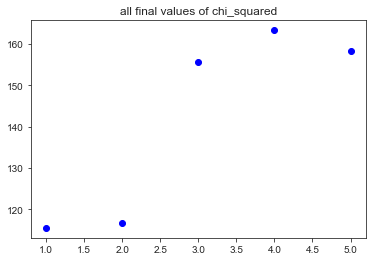

In [202]:
chi_squared = []
energies = []
rates = []
simset = []
final_par = []

file = '../../fits_Stijn/6_9_2019/fit_6_9_2019_sim_'
#model_id = 'Fixed_barrier_1_free_ei_free_kclv'; parnum = '33'
model_id = 'Fixed_barrier_1_fixed_ei_free_kclv'; parnum = '13'

#---------- collect simulations ---------------
for sim in range(1,6):
    sa = pd.read_csv(file +str(sim)+'.txt', delimiter='\t', index_col=False)
    filename = file +str(sim) +'.txt'   
    chi_squared.append(sa.Potential.iloc[np.argmin(sa.Potential)])
    simset.append(filename)
    final_par_temp = sa.loc[np.argmin(sa.Potential),'Parameter 1':'Parameter '+parnum]
    final_par_temp = final_par_temp.values
    
    epsilon,ratestemp = model.unpack_parameters(final_par_temp,model_id,20)
    epsilon[0] = -energiesWT[0]
    energies.append(epsilon)
    rates.append([np.log10(ratesWT[0]),np.log10(ratestemp[1]),np.log10(ratestemp[-1])])
    
    final_par.append(final_par_temp)
    
best_fit = simset[np.argmin(chi_squared)]
print 'best fit: ' + best_fit
print 'all chi_squared: ' + str(chi_squared)

chi_squared = np.array(chi_squared)
number_low_chi = int(np.round(len(chi_squared)*0.75,0))
if number_low_chi != len(chi_squared):
    indices_low_chi = np.argpartition(chi_squared,number_low_chi)[:number_low_chi]
    final_par_low_chi = np.array(final_par)[indices_low_chi]
    energies_low_chi = np.array(energies)[indices_low_chi]
    rates_low_chi = np.array(rates)[indices_low_chi]
    low_chi = chi_squared[indices_low_chi]
else: 
    final_par_low_chi = np.array(final_par)
    energies_low_chi = np.array(energies)
    rates_low_chi = np.array(rates)
    low_chi = chi_squared
plt.plot(range(1,len(chi_squared)+1),chi_squared,'bo')
plt.title('all final values of chi_squared')
parameters = final_par[np.argmin(chi_squared)]

median = np.zeros(len(final_par_low_chi[0]))
median_energies = np.zeros(len(energies_low_chi[0]))
median_rates = np.zeros(len(rates_low_chi[0]))


for i in range(len(final_par_low_chi[0])):
    median_temp = list()
    for j in range(len(final_par_low_chi)):
        median_temp.append(final_par_low_chi[j][i])
    median[i] = np.median(np.array(median_temp))
    
for i in range(len(energies_low_chi[0])):
    median_temp = list()
    for j in range(len(energies_low_chi)):
        median_temp.append(energies_low_chi[j][i])
    median_energies[i] = np.median(np.array(median_temp))
    
for i in range(len(rates_low_chi[0])):
    median_temp = list()
    for j in range(len(rates_low_chi)):
        median_temp.append(rates_low_chi[j][i])
    median_rates[i] = np.median(np.array(median_temp))

print len(final_par_low_chi)

### Show parameters

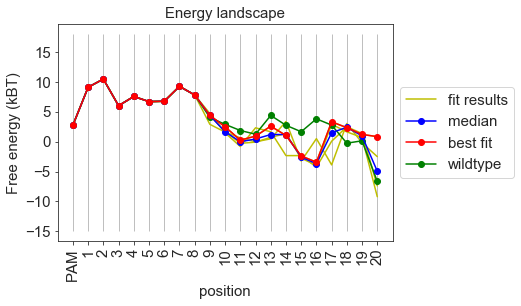

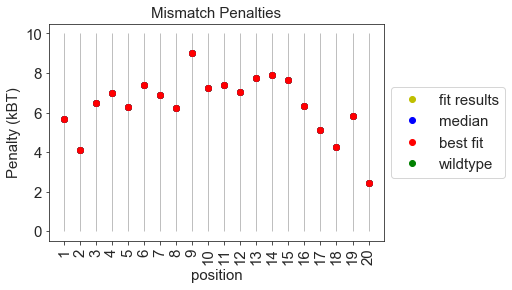

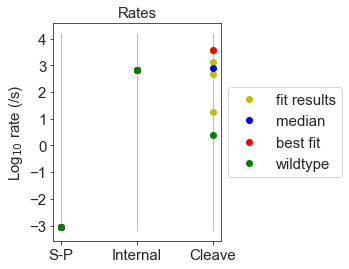

In [203]:
### Landscapes
landscapes = np.zeros([len(energies_low_chi),21])
plt.figure()
for i in range(len(energies_low_chi)):
    plot1, = plt.plot(range(0,21),-np.cumsum(energies_low_chi[i][0:21]),'y-',label='fit results')
    landscapes[i,:] = -np.cumsum(energies_low_chi[i][0:21])
    
medianls = np.median(landscapes, 0)

plot5, = plt.plot(range(0,21),-np.cumsum(np.append(-energiesWT[0],energiesWT[1:21])),'g-o',label='wildtype')
plot2, = plt.plot(range(0,21),medianls,'b-o', label='median')    
plot3, = plt.plot(range(0,21),-np.cumsum(energies[np.argmin(chi_squared)][0:21]),'r-o',label='best fit')


plt.legend(handles=[plot1,plot2,plot3,plot5],loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
plt.xlabel('position',fontsize=15)
plt.ylabel('Free energy (kBT)',fontsize=15)
plt.title('Energy landscape',fontsize=15)
plt.vlines(range(0,21),-15,18,color='grey',linewidth=0.5);
plt.xticks(range(0,21),['PAM'] + range(1,21),fontsize=15,rotation='vertical');
plt.yticks(fontsize=15);
#plt.axis([-1,21,-10,13]);



### Mismatches
plt.figure()
for i in range(len(energies_low_chi)):
    plot1, = plt.plot(range(1,21),energies_low_chi[i][21:41],'yo',label='fit results')

plot4, = plt.plot(range(1,21),energiesWT[21:41],'go',label='wildtype')
    
plot2, = plt.plot(range(1,21),median_energies[21:41],'bo',label='median')
plot3, = plt.plot(range(1,21),energies[np.argmin(chi_squared)][21:41],'ro',label='best fit')

plt.legend(handles=[plot1,plot2,plot3,plot4],loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
plt.xlabel('position',fontsize=15)
plt.ylabel('Penalty (kBT)',fontsize=15)
plt.title('Mismatch Penalties',fontsize=15)
plt.vlines(range(1,21),0,10,color='grey',linewidth=0.5);
plt.xticks(range(1,21),range(1,21),fontsize=15,rotation='vertical');
plt.yticks(fontsize=15);



### Rates
plt.figure(figsize=[3,4])
for i in range(len(rates_low_chi)):
    plot1, = plt.plot(range(1,4),rates_low_chi[i],'yo',label='fit results')

plot2, = plt.plot(range(1,4),median_rates,'bo',label='median')
plot3, = plt.plot(range(1,4),rates[np.argmin(chi_squared)],'ro',label='best fit')
plot4, = plt.plot(range(1,4),[np.log10(ratesWT[0]),np.log10(ratesWT[1]),np.log10(ratesWT[-1])],'go',label='wildtype')
plt.title('Rates',fontsize=15)
plt.ylabel('Log$_{10}$ rate (/s)',fontsize=15)
plt.xticks(range(1,4),['S-P', 'Internal', 'Cleave'],fontsize=15)
plt.vlines(range(1,4),-3.2,4.2,color='grey',linewidth=0.5);
plt.yticks(fontsize=15);
plt.legend(handles=[plot1,plot2,plot3,plot4],loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)

### Show prediction

Text(0.5,1,'Cleavage rate, double mismatches \ntop=model bottom=experiment')

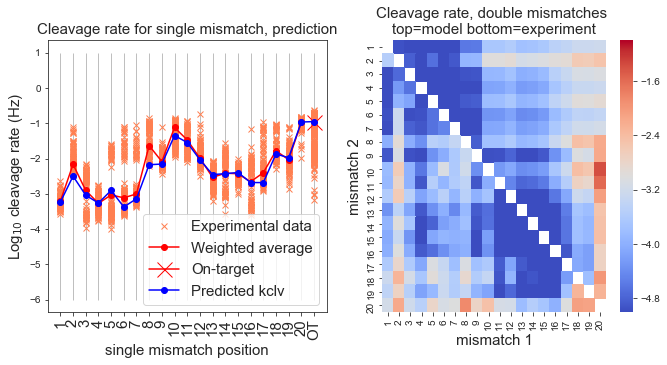

In [204]:
f,ax = plt.subplots(1,2,sharey=False,figsize=[11,5])

k = np.zeros(21)

for i in range(1,22):
    mismatch = [i]
    if i == 21:
        mismatch = []
    k[i-1] = clv.calc_clv_rate_fast(parameters,model_id,mismatch,20)

for i in range(21):
    plot1, = ax[0].plot((i+1)*np.ones(len(kclvcomp[i])),kclvcomp[i],marker='x',color='coral',linewidth=0,label='Experimental data')
plot2, = ax[0].plot(range(1,21),kclv[0:20],marker='o',color='r',label='Weighted average')
plot3, = ax[0].plot(21,kclv[20],marker='x',color='r',markersize=15,label='On-target')
plot4, = ax[0].plot(range(1,22),np.log10(k),color='b',marker='o',label='Predicted kclv')
ax[0].legend(handles=[plot1,plot2,plot3,plot4],fontsize=15)
ax[0].set_xlabel('single mismatch position', fontsize=15)
ax[0].set_ylabel('Log$_{10}$ cleavage rate (Hz)', fontsize=15)
ax[0].set_title('Cleavage rate for single mismatch, prediction', fontsize=15)
ax[0].set_xticks(range(1,22));
ax[0].set_xticklabels(range(1,21)+['OT'],fontsize=15,rotation='vertical')
ax[0].vlines(range(1,22),-6,1,color='grey',linewidth=0.5);


k_matrix = np.zeros([20,20])

for i in range(1,20):
    for j in range(i+1,21):
        mismatch_positions = [i,j]
        k_matrix[i-1,j-1] = np.log10(clv.calc_clv_rate_fast(parameters,model_id,mismatch_positions,20))
        
        
k_df = pd.DataFrame(k_matrix, index=range(1, 21), columns=range(1, 21))

combined_df = k_df + k_double_df

for i in range(1,21):
    combined_df[i].loc[i]= np.nan

sns.heatmap(combined_df, cmap='coolwarm', cbar=True,ax=ax[1], vmin=-5, vmax = -1)
ax[1].set_xlabel('mismatch 1', fontsize=15)
ax[1].set_ylabel('mismatch 2', fontsize=15)
ax[1].set_title('Cleavage rate, double mismatches \ntop=model bottom=experiment', fontsize=15)

### Coarse grained rates

4


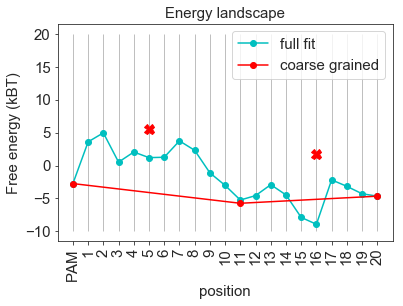

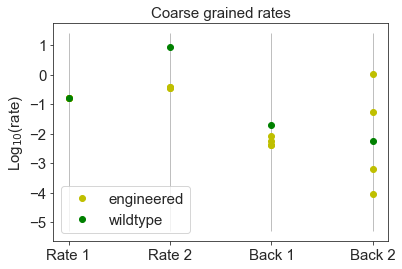

In [205]:
energies20,rates = model.unpack_parameters(parameters,model_id,20)
energies20[0] = -energiesWT[0]

## Mismatch
mismatch = []
for i in mismatch:
    energies20[i] -= energies20[i+20]
    
rates_cg,energies_cg,Istate = cg.coarse_grain_4state(parameters,model_id,mismatch,[7,13])
energies_cg[0] = -energies20[0]
    
barrier1 = -np.log(rates_cg[0]/rates[1])
barrier2 = -np.log(rates_cg[1]/rates[1])
landscape4 = -np.cumsum(energies_cg)
landscape20 = -np.cumsum(np.append(-energies20[0],energies20[1:21]))

plt.figure()
plot5, = plt.plot(range(0,21),landscape20,'c-o',label='full fit')
plot1, = plt.plot([0,Istate,20],landscape4,'r-o',label='coarse grained')
plt.plot([5,16],[barrier1+landscape4[0],barrier2+landscape4[1]],'rX',markersize=10)
plt.legend(handles=[plot5,plot1],fontsize=15)
plt.xlabel('position',fontsize=15)
plt.ylabel('Free energy (kBT)',fontsize=15)
plt.title('Energy landscape',fontsize=15)
if len(mismatch) > 0:
    plt.title('Energy landscape, mismatches at: ' + str(mismatch),fontsize=15)
plt.vlines(range(0,21),-10,20,color='grey',linewidth=0.5);
plt.xticks(range(0,21),['PAM'] + range(1,21),fontsize=15,rotation='vertical');
plt.yticks(fontsize=15);





### Looping over all good fits:
rates_list = []
for para in final_par_low_chi:
    
    rates_cg,_,_ = cg.coarse_grain_4state(para,model_id,mismatch,[7,13])
    rates_list.append(np.log10(np.array(rates_cg)))
print len(rates_list)


### WT coarse graining
rates_cgWT,_,_ = cg.coarse_grain_4state(parameters_clv,model_ID_clv,mismatch,[7,13])

plt.figure(figsize = [6,4])
for i in range(len(rates_list)):
    if rates_list[i][1]>np.log10(rates_cgWT[1]):
        plt.plot(range(1,5),rates_list[i],'ro',linewidth=0,label='engineered')
    else:
        plot1, = plt.plot(range(1,5),rates_list[i],'yo',linewidth=0,label='engineered')
plot4, = plt.plot(range(1,5),np.log10(np.array(rates_cgWT)),'go',linewidth=0,label='wildtype')
plt.title('Coarse grained rates',fontsize=15)
if len(mismatch) > 0:
    plt.title('Coarse grained rates, \nmismatches at: ' + str(mismatch),fontsize=15)
plt.vlines(range(1,5),-5.3,1.4,color='grey',linewidth=0.5);
plt.xticks(range(1,5),['Rate 1','Rate 2','Back 1','Back 2'],fontsize=15);
plt.ylabel('Log$_{10}$(rate)',fontsize=15)
plt.yticks(fontsize=15)
#plt.axis([0.5,2.5,-3.5,1.5])
plt.legend(handles=[plot1,plot4],fontsize=15)

### Correlation

Text(0,0.5,'Measured log$_{10}$ cleavage rate (Hz)')

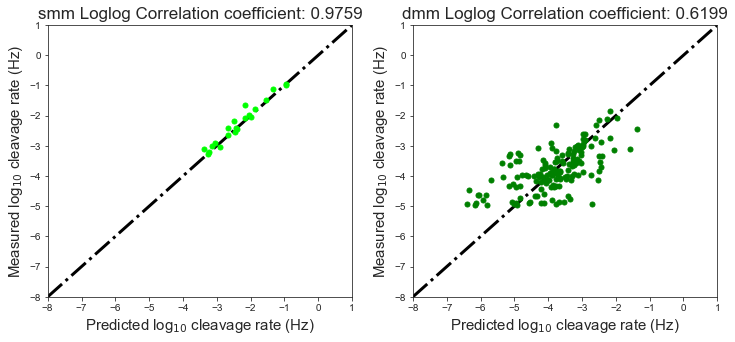

In [206]:
datacleave = []
fitcleave = []
datacleave2 = []
fitcleave2 = []

for i in range(len(xdata)):
    cleavagetemp = np.log10(clv.calc_clv_rate_fast(parameters,model_id,xdata[i],20))
    if len(xdata[i])<2:
        for j in range(len(ydata[i])):
            if (ydata[i][j])>(-5) and ydata[i][j]<0:
                datacleave.append(ydata[i][j])
                fitcleave.append(cleavagetemp)
    if len(xdata[i])==2:
        for j in range(len(ydata[i])):
            if (ydata[i][j])>(-5) and ydata[i][j]<0:
                datacleave2.append(ydata[i][j])
                fitcleave2.append(cleavagetemp)
        
f,ax = plt.subplots(1,2,sharey=False,figsize=[12,5])

ax[0].plot([-8,1],[-8,1],'k-.',linewidth=3)
ax[0].plot(fitcleave,datacleave,marker='o',markersize=5,color='lime',linewidth=0.0)
ax[0].axis([-8,1,-8,1])
ax[0].set_title('smm Loglog Correlation coefficient: ' + str(np.round(np.corrcoef([datacleave,fitcleave])[0][1],4)), fontsize=17)
ax[0].set_xlabel('Predicted log$_{10}$ cleavage rate (Hz)',fontsize=15)
ax[0].set_ylabel('Measured log$_{10}$ cleavage rate (Hz)',fontsize=15)

ax[1].plot([-8,1],[-8,1],'k-.',linewidth=3)
ax[1].plot(fitcleave2,datacleave2,marker='o',markersize=5,color='g',linewidth=0.0)
ax[1].axis([-8,1,-8,1])
ax[1].set_title('dmm Loglog Correlation coefficient: ' + str(np.round(np.corrcoef([datacleave2,fitcleave2])[0][1],4)), fontsize=17)
ax[1].set_xlabel('Predicted log$_{10}$ cleavage rate (Hz)',fontsize=15)
ax[1].set_ylabel('Measured log$_{10}$ cleavage rate (Hz)',fontsize=15)